# 0.0 Imports

In [3]:
!pip install fast_ml --upgrade

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import inflection

from IPython.display import Image
from IPython.core.display import HTML

from fast_ml.model_development import train_valid_test_split

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
import pickle

## 0.1 Helper functions

In [94]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:85% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

In [8]:
def get_summary(numerical_attributes):
    
    # Central Tendency - mean, meadina 
    ct1 = pd.DataFrame( numerical_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( numerical_attributes.apply( np.median ) ).T

    # dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( numerical_attributes.apply( np.std ) ).T 
    d2 = pd.DataFrame( numerical_attributes.apply( min ) ).T 
    d3 = pd.DataFrame( numerical_attributes.apply( max ) ).T 
    d4 = pd.DataFrame( numerical_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    d5 = pd.DataFrame( numerical_attributes.apply( lambda x: x.skew() ) ).T 
    d6 = pd.DataFrame( numerical_attributes.apply( lambda x: x.kurtosis() ) ).T 

    # concatenar
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m

In [9]:
def cross_validation(X_train, y_train, n_folds, model_name, model, verbose=True):
    # generate k-fold
    f1_scores = []
    n_folds = n_folds
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    i=1
    if verbose:
        for train_ix, val_ix in kfold.split(X_train, y_train):
            print('Fold Nº: {}/{}'.format(i, n_folds))
            # get fold
            X_train_fold = X_train.iloc[train_ix]
            y_train_fold = y_train.iloc[train_ix]

            X_val_fold = X_train.iloc[val_ix]
            y_val_fold = y_train.iloc[val_ix]


            # training model
            m = model.fit(X_train_fold, y_train_fold)

            # prediction
            pred_val = m.predict(X_val_fold)

            # metric
            # F1-Score
            f1_fold = f1_score(pred_val,y_val_fold)
            f1_scores.append(f1_fold)

            i +=1
    return pd.DataFrame({'Model Name': model_name,
                         'Avg F1-Score':np.round(np.mean(f1_scores),3).astype(str)+ '+/-' + np.round(np.std(f1_scores),3).astype(str)}, index=[0])

In [10]:
def f1_score_metric(model_name, y_test, pred):
    return pd.DataFrame({'Model Name': model_name,
                        'F1 Score': f1_score(pred,y_test).round(3)}, index=[0])

In [11]:
#suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [12]:
def categorical_metrics(data, col):
    """
    Shows the the absolute and percent values in categorical variables.

    Args:
        data ([object]): Insert all categorical attributes in the dataset

    Returns:
        [dataframe]: A dataframe with absolute and percent values
    """
    


    return pd.DataFrame({'absolute': data[col].value_counts(), 'percent %': data[col].value_counts(normalize = True) * 100 })

## 0.2 Load Data

In [13]:
df_raw = pd.read_csv('../data/raw/churn.csv')
df_raw.drop('RowNumber', axis=1, inplace=True)

# 1.0 Data Description

In [14]:
df1 = df_raw.copy()
df1.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 1.1 Data dimension

In [15]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 10000
Number of columns: 13


## 1.2 Rename Columns

In [16]:
cols_old = df1.columns.to_list()

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new
df1.columns

Index(['customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age',
       'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## 1.3 Data Types

In [17]:
df1.dtypes

customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4 Check NAs

In [18]:
df1.isna().sum()

customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5 Descriptive Statistics

In [19]:
num_attributes = df1.select_dtypes( include = [ 'int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [20]:
get_summary(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,customer_id,15565701.00,15815690.00,249989.00,15690940.57,15690738.00,71932.59,0.00,-1.20
1,credit_score,350.00,850.00,500.00,650.53,652.00,96.65,-0.07,-0.43
2,age,18.00,92.00,74.00,38.92,37.00,10.49,1.01,1.40
3,tenure,0.00,10.00,10.00,5.01,5.00,2.89,0.01,-1.17
4,balance,0.00,250898.09,250898.09,76485.89,97198.54,62394.29,-0.14,-1.49
5,num_of_products,1.00,4.00,3.00,1.53,1.00,0.58,0.75,0.58
6,has_cr_card,0.00,1.00,1.00,0.71,1.00,0.46,-0.90,-1.19
7,is_active_member,0.00,1.00,1.00,0.52,1.00,0.50,-0.06,-2.00
8,estimated_salary,11.58,199992.48,199980.90,100090.24,100193.91,57507.62,0.00,-1.18
9,exited,0.00,1.00,1.00,0.20,0.00,0.40,1.47,0.17


In [21]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

surname      2932
geography       3
gender          2
dtype: int64

# 2.0 Feature Engeenering

In [22]:
df2 = df1.copy()

In [23]:
# get feature of bined ages

# 3.0 Feature Filtering

In [24]:
df3 = df2.copy()

In [25]:
df3.drop(['customer_id','surname'], axis=1, inplace=True)

In [26]:
df3.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 4.0 Exploratory Data Analysis

In [27]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Target Variable

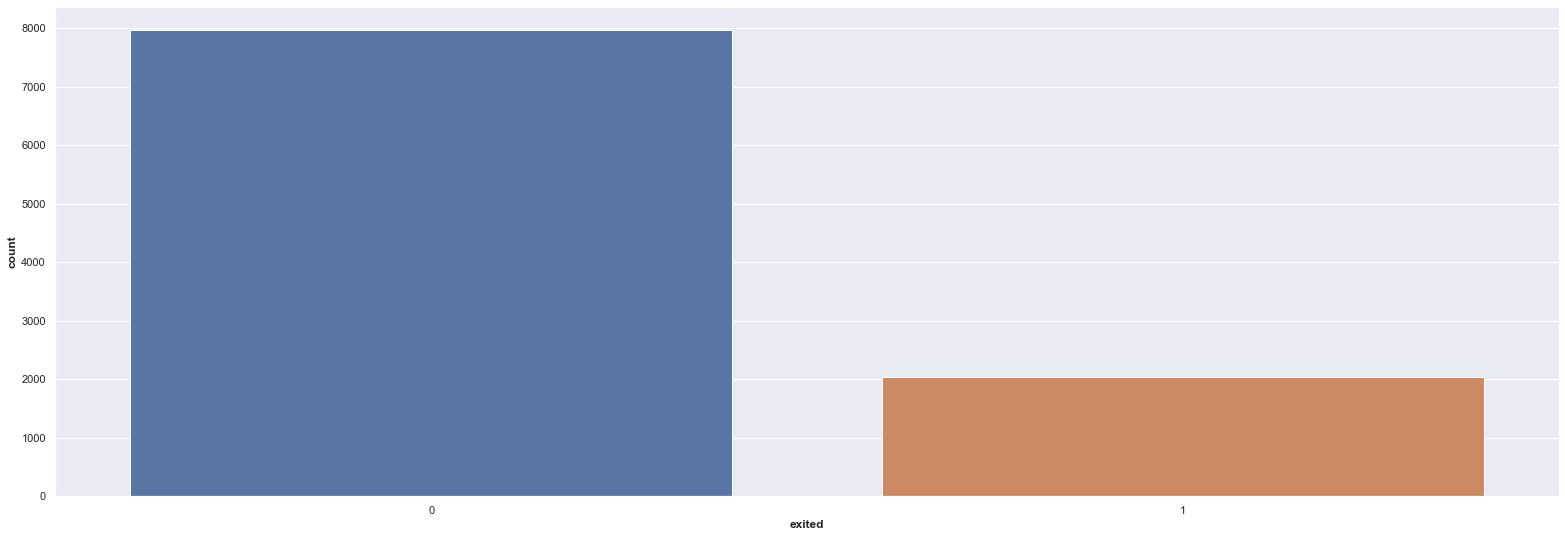

In [95]:
sns.countplot(x='exited', data=df4);

In [29]:
categorical_metrics(df4, 'exited')

,absolute,percent %
0,7963,79.63
1,2037,20.37


### 4.1.2 Numerical Variables

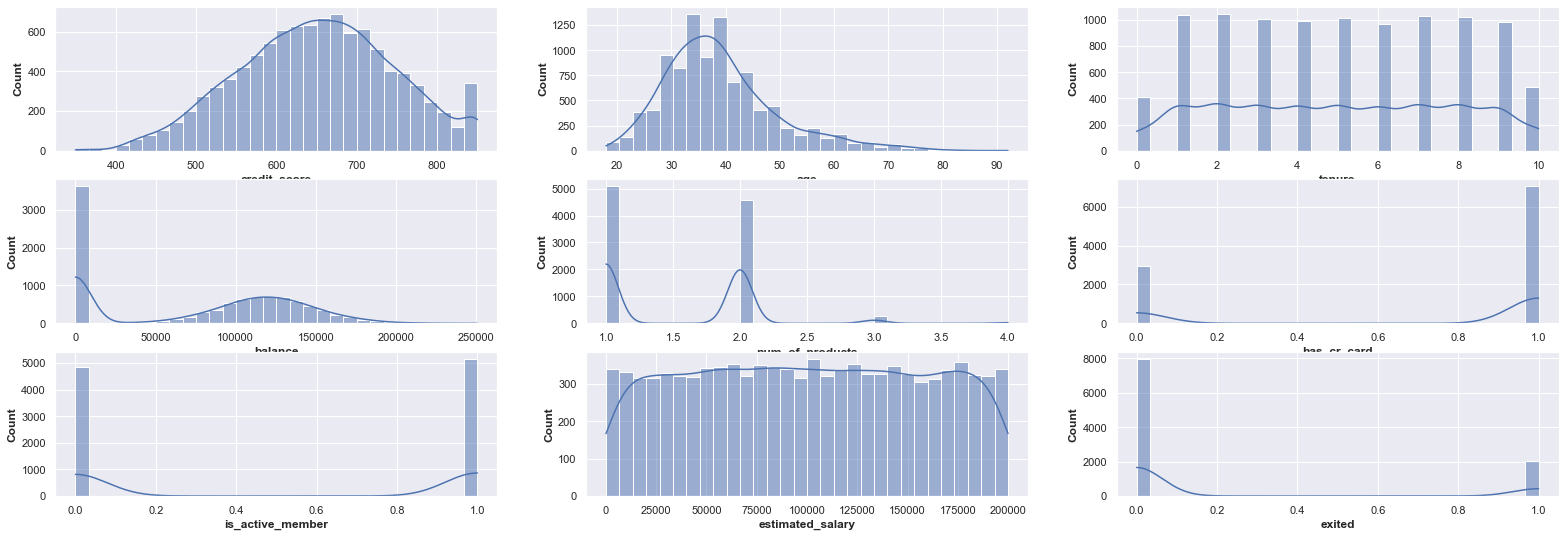

In [96]:
num_attributes = df4.select_dtypes(exclude='object')
columns = num_attributes.columns;
j = 1

for i in columns:
    plt.subplot(3, 3, j)
    sns.histplot(x=i, data=df4, kde=True, bins=30);
    
    j += 1

### 4.1.3 Categorical Variables

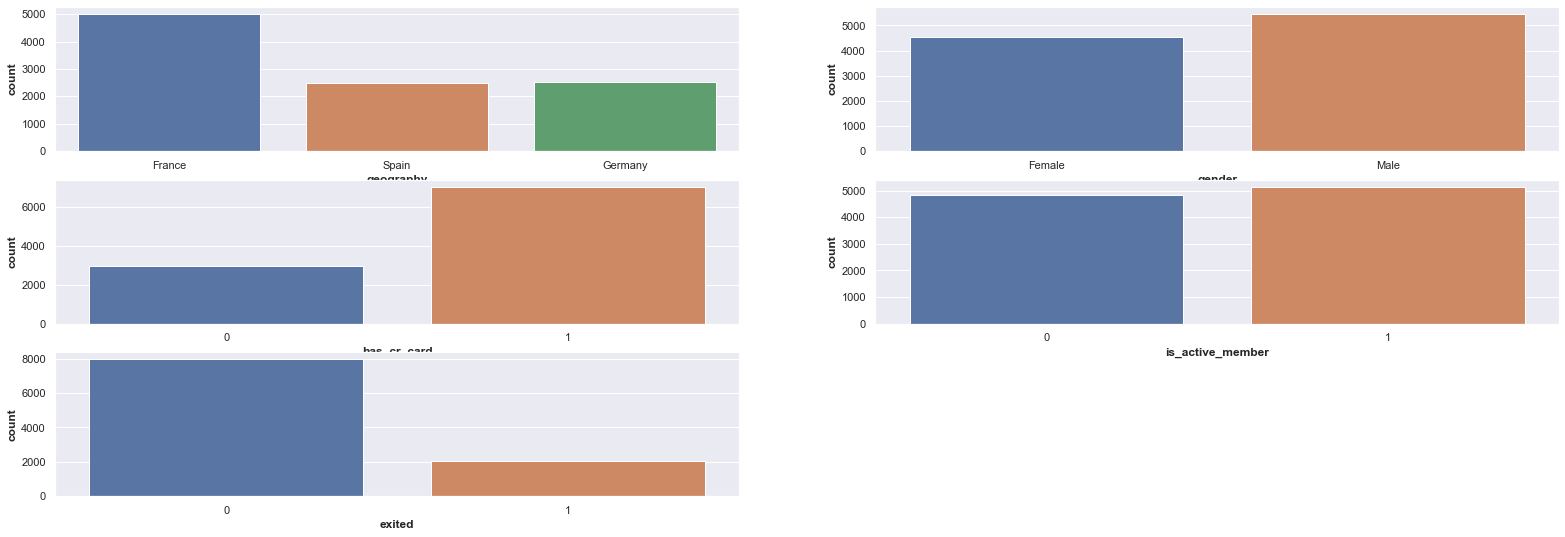

In [97]:
columns = ['geography', 'gender', 'has_cr_card', 'is_active_member', 'exited']
j = 1

for i in columns:
    plt.subplot(3, 2, j)
    sns.countplot(x=i, data=df4);
    j += 1

## 4.2 Multivariate Analysis

<AxesSubplot:>

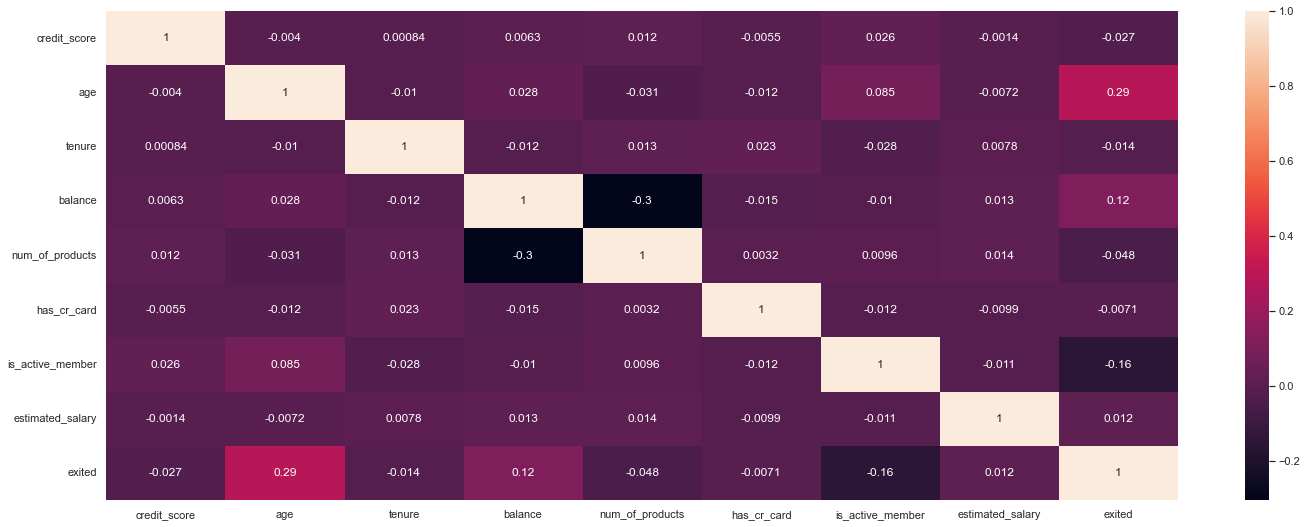

In [91]:
num_attr = df4.select_dtypes( include = ['int64' , 'float64'] )
sns.heatmap( num_attr.corr(method='pearson'), annot=True)

## 4.3 Bivariate Analysis

H1: People who receive a salary below the average salary are more likely to Churn
H2: People with less products purchased are more likely to Churn
H3: Younger people are more likely to Churn
H4: Credit card customers are more active.
H5: People who don't have a credit card are more likely to Churn

### H1: People who receive a salary below the average salary are more likely to Churn

In [34]:
#False, they have relatively the same median salary.

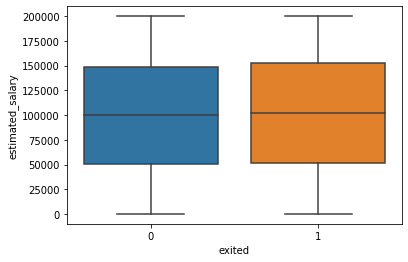

In [35]:
sns.boxplot(x='exited', y='estimated_salary', data=df4);

### H2: People with less products purchased are more likely to Churn

In [36]:
df4.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


,exited,num_of_products
0,0,1.54
1,1,1.48


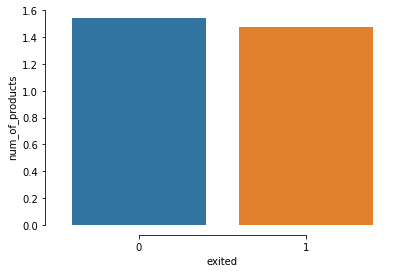

In [37]:
aux = df4[['num_of_products', 'exited']].groupby( 'exited' ).mean().reset_index()
sns.barplot( x='exited', y='num_of_products', data=aux )
sns.despine(offset = 10, trim = True);

aux.head()

### H3: Younger people are more likely to Churn

In [38]:
df4[['exited', 'age']].groupby(['exited']).mean().reset_index()

,exited,age
0,0,37.41
1,1,44.84


<AxesSubplot:xlabel='age', ylabel='Count'>

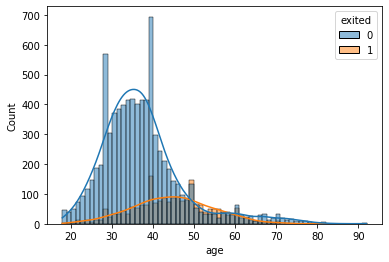

In [39]:
sns.histplot(x='age', data=df4, hue='exited', kde=True)

### H4: Credit card customers are more active.

<AxesSubplot:xlabel='has_cr_card', ylabel='count'>

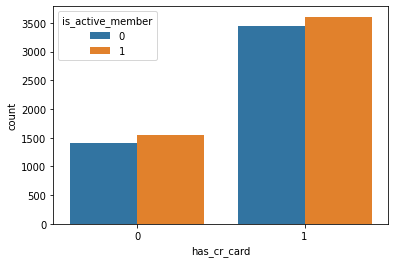

In [40]:
sns.countplot(x='has_cr_card', hue='is_active_member', data=df4)

### H5: People who don't have a credit card are more likely to Churn

<AxesSubplot:xlabel='has_cr_card', ylabel='count'>

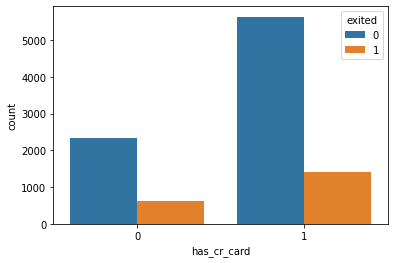

In [41]:
sns.countplot(x='has_cr_card', hue='exited', data=df4)

# 5.0 Data Preparation

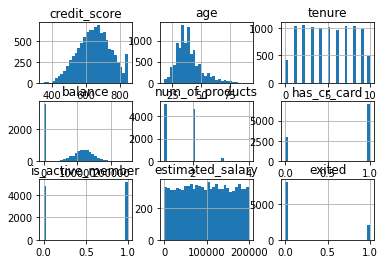

In [61]:
df5 = df4.copy()
df5.hist(bins = 30);

In [62]:
df5.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [66]:
x_train, y_train, x_val, y_val, x_test, y_test = train_valid_test_split(df5, target = 'exited', 
                                                     train_size=0.8, valid_size=0.1, test_size=0.1)

## 5.1 Encoding

In [67]:
# Gender Encoding
x_train['gender'] = x_train['gender'].map({'Male': 0, 'Female': 1})
x_test['gender'] = x_test['gender'].map({'Male': 0, 'Female': 1})
x_val['gender'] = x_val['gender'].map({'Male': 0, 'Female': 1})

#Geography encoding
x_train = pd.get_dummies( x_train, prefix=['geography'], columns=['geography'] )
x_test = pd.get_dummies( x_test, prefix=['geography'], columns=['geography'] )
x_val = pd.get_dummies( x_val, prefix=['geography'], columns=['geography'] )

x_train.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_France,geography_Germany,geography_Spain
9650,834,0,33,5,0.00,2,1,0,66285.18,0,0,1
183,636,0,42,2,0.00,2,1,1,55470.78,1,0,0
3397,820,0,33,2,132150.26,2,1,0,23067.97,1,0,0
7385,660,0,38,4,0.00,2,0,0,88080.43,1,0,0
1071,695,0,52,8,103023.26,1,1,1,22485.64,0,1,0


## 5.1 Rescalling

In [76]:
#Defining scalers
rs = RobustScaler()
ss = StandardScaler()
mms = MinMaxScaler()

#Credit Score
x_train['credit_score'] = rs.fit_transform(x_train[['credit_score']].values)
pickle.dump(rs, open('../parameters/credit_score_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
x_test['credit_score'] = rs.transform(x_test[['credit_score']].values)
x_val['credit_score'] = rs.transform(x_val[['credit_score']].values)

#Age
x_train['age'] = ss.fit_transform(x_train[['age']].values)
pickle.dump(ss, open('../parameters/age_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
x_test['age'] = ss.transform(x_test[['age']].values)
x_val['age'] = ss.transform(x_val[['age']].values)

#Estimated Salary
x_train['estimated_salary'] = rs.fit_transform(x_train[['estimated_salary']].values)
pickle.dump(rs, open('../parameters/estimated_salary_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
x_test['estimated_salary'] = rs.transform(x_test[['estimated_salary']].values)
x_val['estimated_salary'] = rs.transform(x_val[['estimated_salary']].values)

#Tenure
x_train['tenure'] = mms.fit_transform(x_train[['tenure']].values)
pickle.dump(mms, open('../parameters/tenure_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
x_test['tenure'] = mms.transform(x_test[['tenure']].values)
x_val['tenure'] = mms.transform(x_val[['tenure']].values)

#Balance
x_train['balance'] = rs.fit_transform(x_train[['balance']].values)
pickle.dump(rs, open('../parameters/balance_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
x_test['balance'] = rs.transform(x_test[['balance']].values)
x_val['balance'] = rs.transform(x_val[['balance']].values)

x_train.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_France,geography_Germany,geography_Spain
9650,1.34,0,-0.56,0.50,-0.76,2,1,0,-0.35,0,0,1
183,-0.13,0,0.30,0.20,-0.76,2,1,1,-0.46,1,0,0
3397,1.24,0,-0.56,0.20,0.27,2,1,0,-0.79,1,0,0
7385,0.05,0,-0.08,0.40,-0.76,2,0,0,-0.12,1,0,0
1071,0.31,0,1.25,0.80,0.05,1,1,1,-0.79,0,1,0


# 6.0 Feature Selection

In [41]:
df6 = df5.copy()

# 7.0 Machine Learning Modelling

In [72]:
df7 = df6.copy()

# 8.0 Hyperparameter Fine-Tunning

In [92]:
df8 = df7.copy()

# 9.0 Churn Analysis

In [93]:
df9 = df8.copy()

# 10.0 Business Results

## 10.1 Business Analysis

# 11.0 Deploy

## 11.1 Churn Probability Class